# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install Packages

In [2]:
!pip install rasterio matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 84.3 MB/s eta 0:00:00


# Extract zip files

In [24]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/sentinel2/ps_2025.zip'
extract_dir = '/content/drive/MyDrive/sentinel2/ps2025'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Files extracted to:", extract_dir)


Files extracted to: /content/drive/MyDrive/sentinel2/ps2025


# Code

In [8]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.transform import rowcol

folder = '/content/drive/MyDrive/sentinel2/cherry_20250504/S2B_MSIL2A_20250504T163839_N0511_R126_T16TFQ_20250504T203857.SAFE/GRANULE/L2A_T16TFQ_A042623_20250504T164756/IMG_DATA/R10m/'
# Paths to your .SAFE bands (adjust paths)
b02_path = folder + 'B02.jp2'  # Blue
b03_path = folder + 'B03.jp2'  # Green
b04_path = folder + 'B04.jp2'  # Red
# b08_path = folder + 'B08.jp2'  # NIR

with rasterio.open(b02_path) as src:
    blue = src.read(1)
    transform = src.transform
with rasterio.open(b03_path) as src: green = src.read(1)
with rasterio.open(b04_path) as src: red = src.read(1)
# with rasterio.open(b08_path) as src: nir = src.read(1)

In [9]:
with rasterio.open(folder + 'B03.jp2') as src:
    print("Width (pixels):", src.width)
    print("Height (pixels):", src.height)
    print("Number of bands:", src.count)
    print("Pixel size (meters):", src.res)

Width (pixels): 10980
Height (pixels): 10980
Number of bands: 1
Pixel size (meters): (10.0, 10.0)


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Assuming b02_path, b03_path, and b04_path are already defined from previous cells

# Read the full bands
with rasterio.open(b04_path) as src:
    red = src.read(1) / 10000.0 # Normalize
with rasterio.open(b03_path) as src:
    green = src.read(1) / 10000.0 # Normalize
with rasterio.open(b02_path) as src:
    blue = src.read(1) / 10000.0 # Normalize

# Stack into RGB
rgb = np.dstack((red, green, blue))

# Plot
plt.figure(figsize=(12, 12)) # Adjust figure size as needed
plt.imshow(rgb)
plt.title('Full Image - True Color')
plt.axis('off')
plt.show()

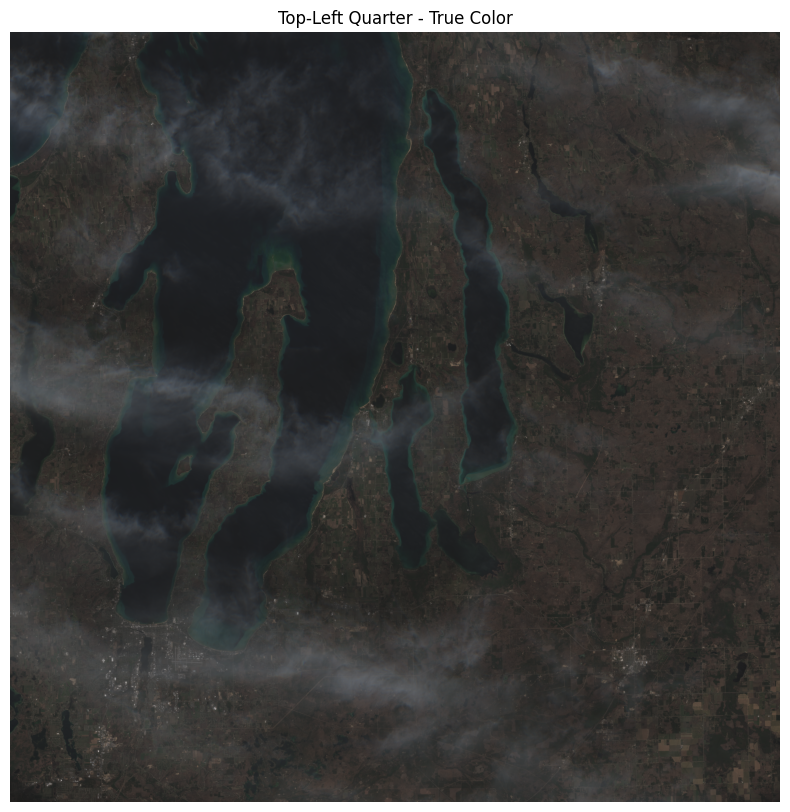

In [3]:
import rasterio
from rasterio.windows import Window
import numpy as np
import matplotlib.pyplot as plt

# Open one band to get width/height
with rasterio.open(b04_path) as src:
    width = src.width
    height = src.height

# Define window for top-left quarter
quarter_window = Window(0, 0, width // 2, height // 2)

# Read only the window for each band
with rasterio.open(b04_path) as src:
    red = src.read(1, window=quarter_window) / 10000.0  # normalize
with rasterio.open(b03_path) as src:
    green = src.read(1, window=quarter_window) / 10000.0
with rasterio.open(b02_path) as src:
    blue = src.read(1, window=quarter_window) / 10000.0

# Stack into RGB
rgb = np.dstack((red, green, blue))

# Plot
plt.figure(figsize=(10,10))
plt.imshow(rgb)
plt.title('Top-Left Quarter - True Color')
plt.axis('off')
plt.show()


Pixel location in raster -> Row: 3451 Col: 2305


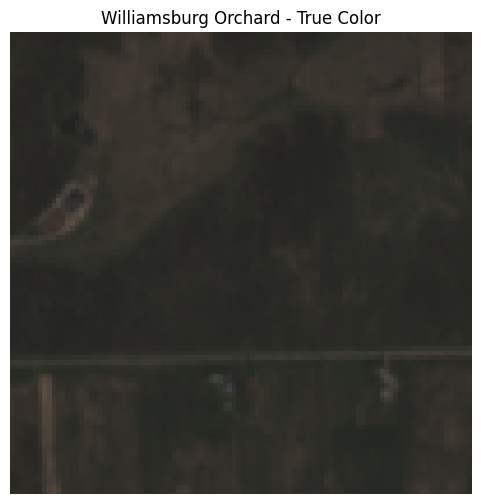

In [15]:
import rasterio
from rasterio.windows import Window
from pyproj import Transformer
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Paths to your Sentinel-2 R10m bands
# -----------------------------

# -----------------------------
# Latitude/Longitude of orchard (decimal degrees)
# -----------------------------
lat, lon = 44.8325, -85.4432
window_size = 50  # pixels around orchard (~100x100 pixel window)

# -----------------------------
# Open one band to get raster CRS
# -----------------------------
with rasterio.open(b04_path) as src:
    raster_crs = src.crs
    width = src.width
    height = src.height

# -----------------------------
# Transform lat/lon to raster CRS
# -----------------------------
transformer = Transformer.from_crs("EPSG:4326", raster_crs, always_xy=True)
x, y = transformer.transform(lon, lat)

# -----------------------------
# Find pixel row/col in the raster
# -----------------------------
with rasterio.open(b04_path) as src:
    row, col = src.index(x, y)
    print("Pixel location in raster -> Row:", row, "Col:", col)

    # Define window bounds around orchard
    row_start = max(row - window_size, 0)
    row_end = min(row + window_size, src.height)
    col_start = max(col - window_size, 0)
    col_end = min(col + window_size, src.width)

    window = Window(col_start, row_start, col_end - col_start, row_end - row_start)

    # Read the window for each band
    red = src.read(1, window=window) / 10000.0
with rasterio.open(b03_path) as src:
    green = src.read(1, window=window) / 10000.0
with rasterio.open(b02_path) as src:
    blue = src.read(1, window=window) / 10000.0

# -----------------------------
# Stack into RGB and plot
# -----------------------------
rgb = np.dstack((red, green, blue))

plt.figure(figsize=(6,6))
plt.imshow(rgb)
plt.title('Williamsburg Orchard - True Color')
plt.axis('off')
plt.show()

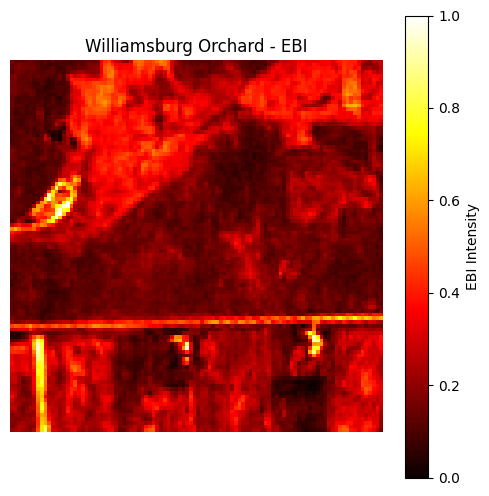

In [21]:
# -----------------------------
# Calculate EBI
# -----------------------------
# Avoid division by zero
epsilon = 1e-6
ebi = (red + green + blue) / ((green / (blue)) * (red - blue + 256))

# Optional: normalize for plotting
ebi_norm = (ebi - np.min(ebi)) / (np.max(ebi) - np.min(ebi))

# -----------------------------
# Plot EBI
# -----------------------------
plt.figure(figsize=(6,6))
plt.imshow(ebi_norm, cmap='hot')  # 'hot', 'magma', 'viridis' etc.
plt.colorbar(label='EBI Intensity')
plt.title('Williamsburg Orchard - EBI')
plt.axis('off')
plt.show()


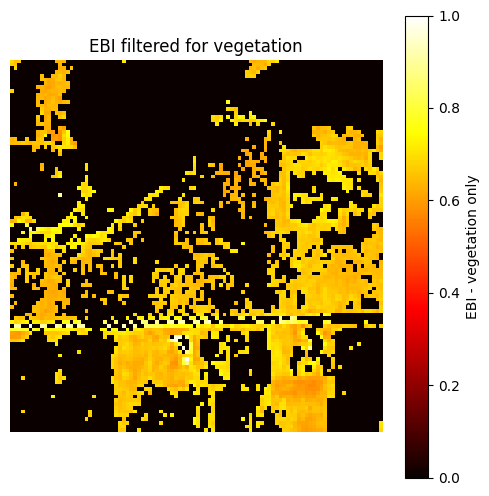

In [22]:
# Compute simple vegetation mask
vegetation_mask = (green > red) & (green > blue)  # green-dominant pixels

# Apply mask to EBI
ebi_veg = ebi.copy()
ebi_veg[~vegetation_mask] = 0  # zero out non-vegetation areas

# Normalize for plotting
ebi_veg_norm = (ebi_veg - np.min(ebi_veg)) / (np.max(ebi_veg) - np.min(ebi_veg))

plt.figure(figsize=(6,6))
plt.imshow(ebi_veg_norm, cmap='hot')
plt.colorbar(label='EBI - vegetation only')
plt.title('EBI filtered for vegetation')
plt.axis('off')
plt.show()


/tmp/ipython-input-1836625073.py:27: RuntimeWarning: invalid value encountered in divide
  ebi = (red + green + blue) / (green / blue) / (red - blue + 256)


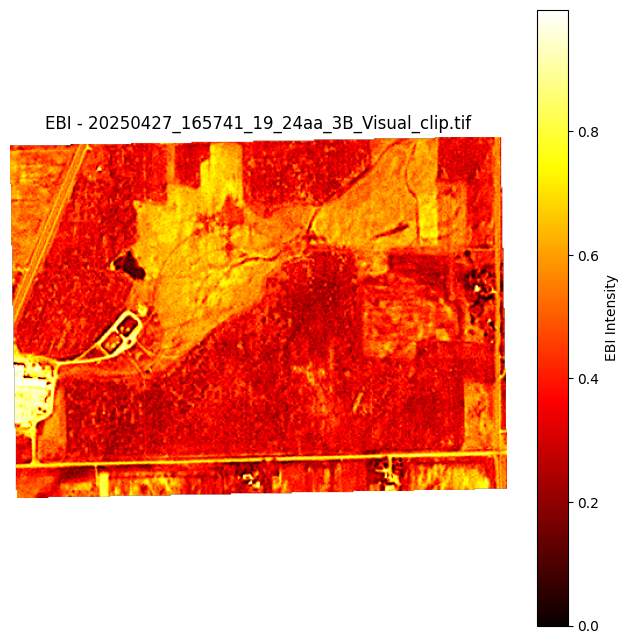

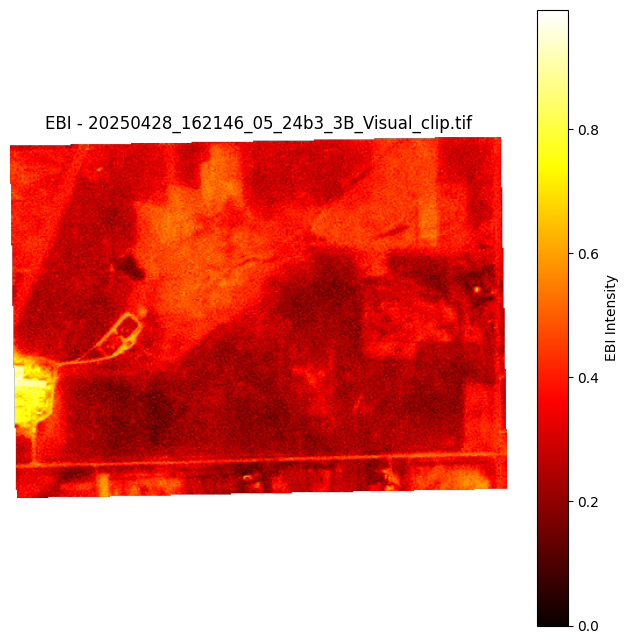

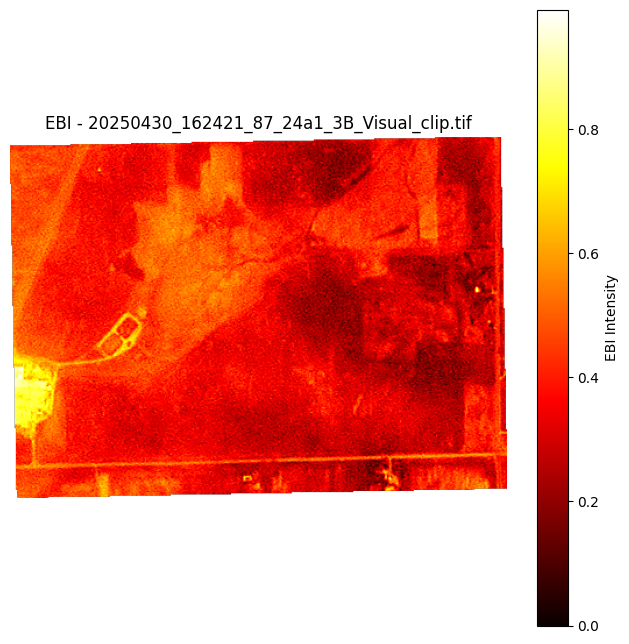

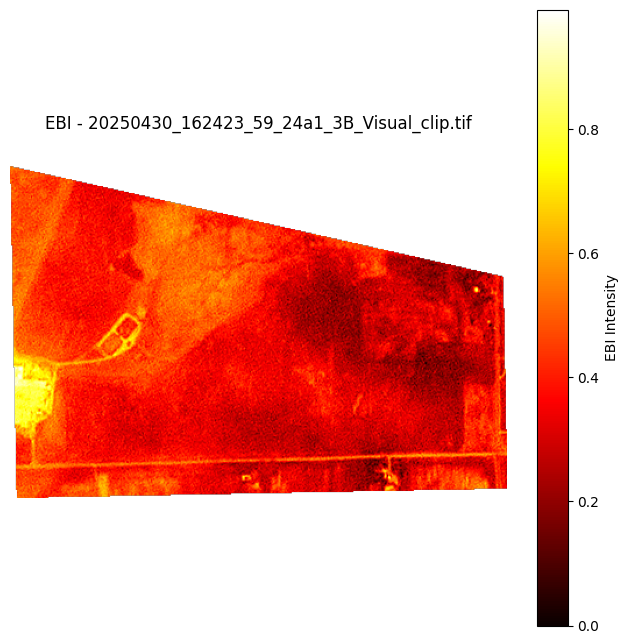

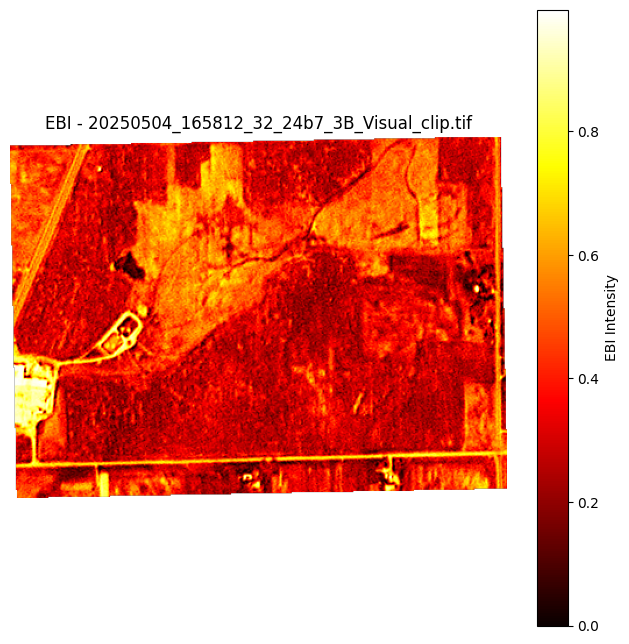

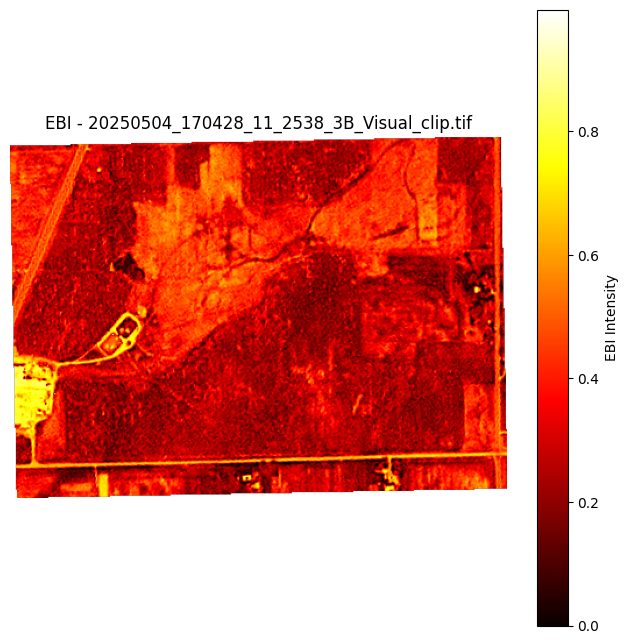

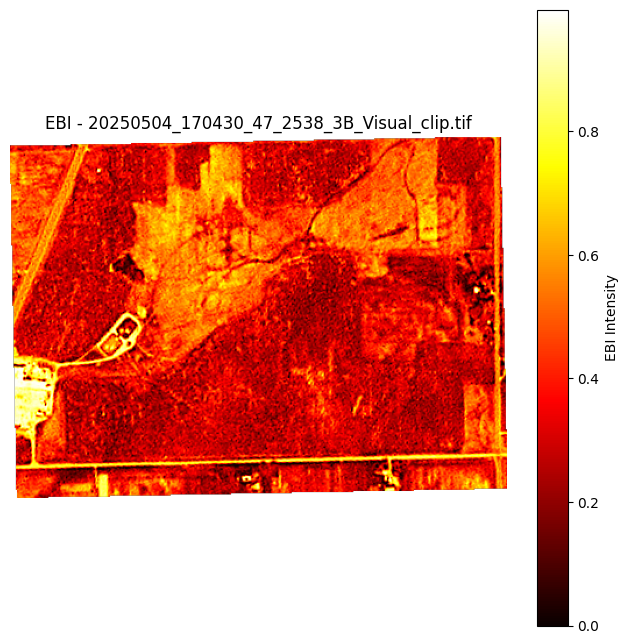

In [30]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# -----------------------------
# Configuration
# -----------------------------
folder = "/content/drive/MyDrive/sentinel2/ps2025/PSScene/rgb"   # change to your folder path
epsilon = 1e-6

# Collect all GeoTIFFs in folder
tif_files = sorted(glob.glob(os.path.join(folder, "*.tif")))

# -----------------------------
# Loop over each tif file
# -----------------------------
for tif_path in tif_files:
    with rasterio.open(tif_path) as src:
        # PlanetScope band order: B=1, G=2, R=3, NIR=4
        blue  = src.read(1).astype(float) / 10000.0
        green = src.read(2).astype(float) / 10000.0
        red   = src.read(3).astype(float) / 10000.0

        # Compute EBI (with safeguard)
        ebi = (red + green + blue) / (green / blue) / (red - blue + 256)
        ebi_norm = (ebi - np.nanmin(ebi)) / (np.nanmax(ebi) - np.nanmin(ebi) + epsilon)

        # Plot result
        plt.figure(figsize=(8, 8))
        plt.imshow(ebi_norm, cmap="hot")
        plt.colorbar(label="EBI Intensity")
        plt.title(f"EBI - {os.path.basename(tif_path)}")
        plt.axis("off")
        plt.show()


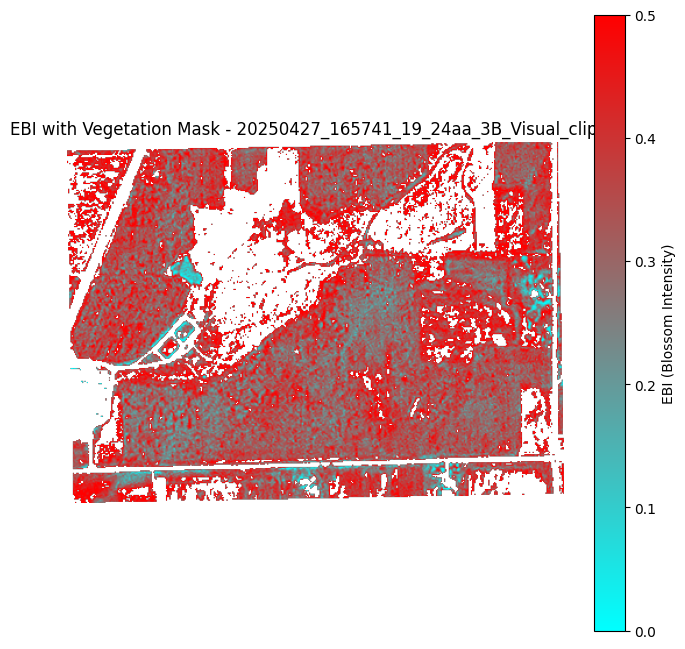

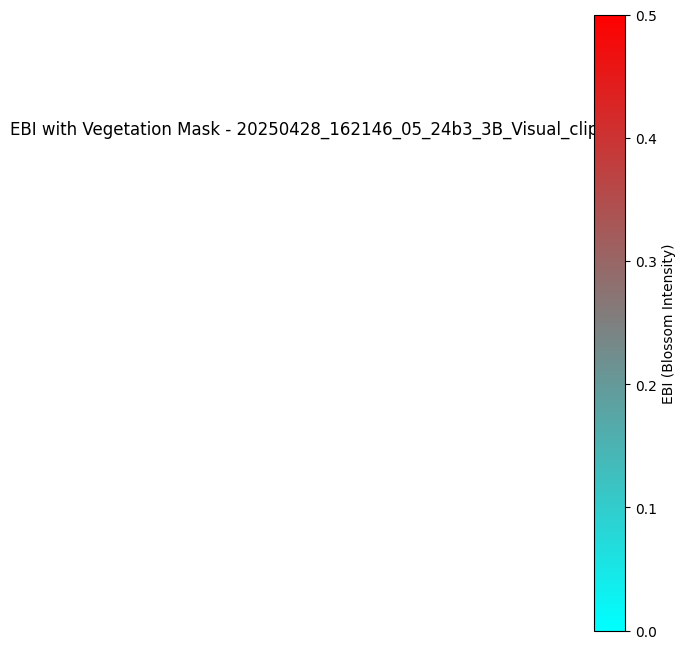

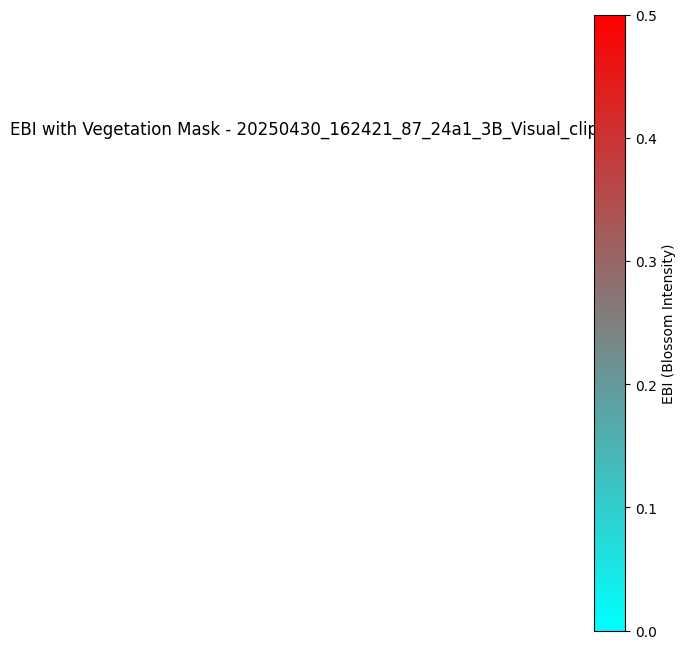

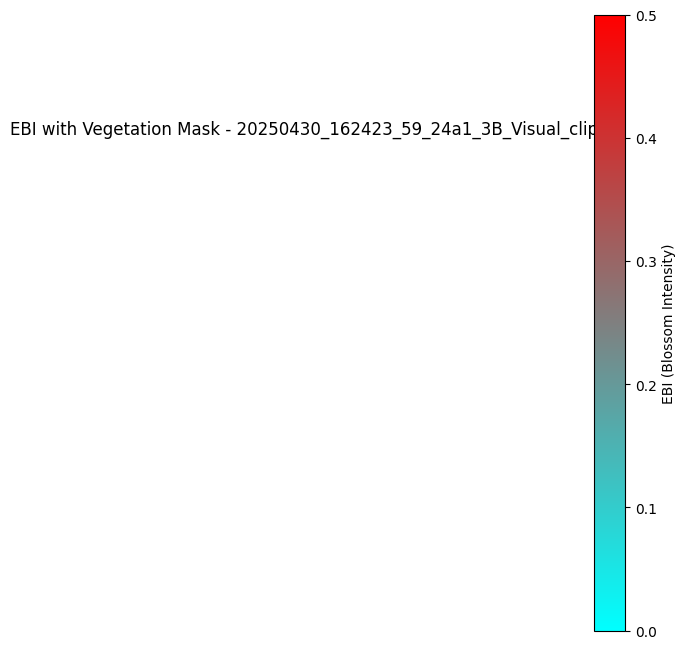

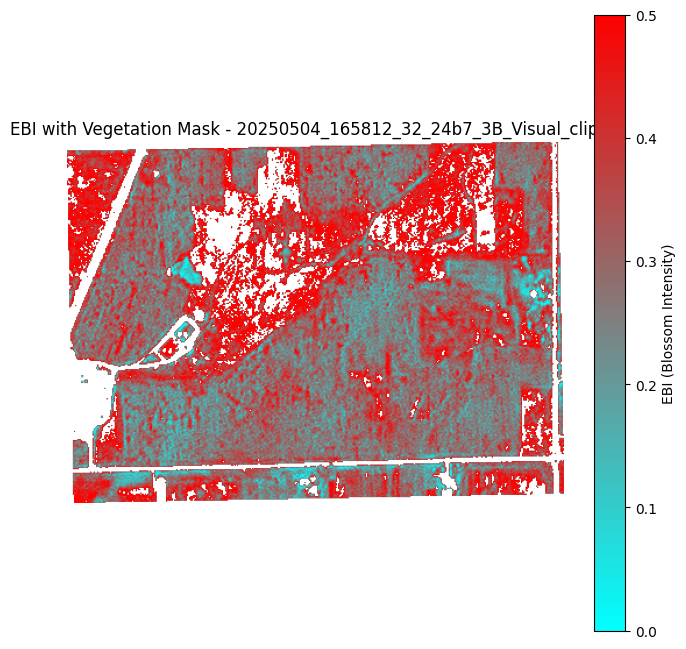

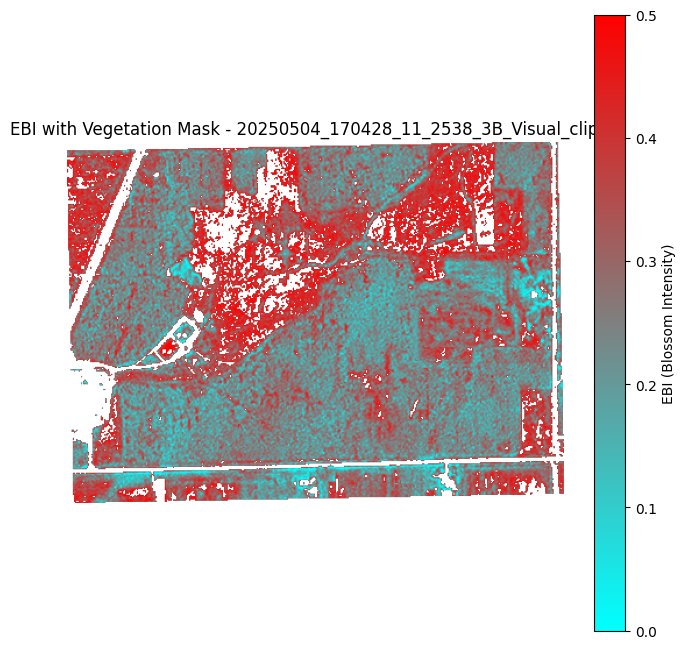

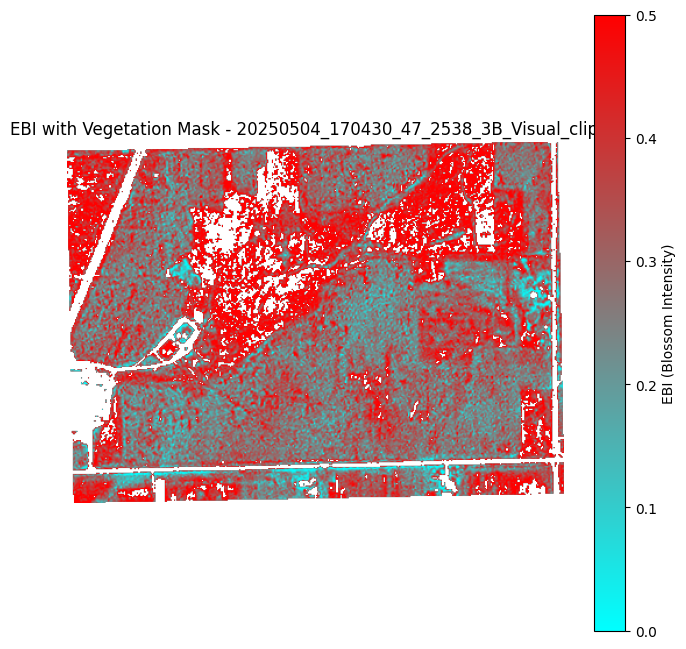

In [49]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import glob
import os

# -----------------------------
# Configuration
# -----------------------------
folder = "/content/drive/MyDrive/sentinel2/ps2025/PSScene/rgb"
epsilon = 1e-6

# Collect all GeoTIFFs in folder
tif_files = sorted(glob.glob(os.path.join(folder, "*.tif")))

# -----------------------------
# Loop over each tif file
# -----------------------------
for tif_path in tif_files:
    with rasterio.open(tif_path) as src:
        # PlanetScope band order: B=1, G=2, R=3, NIR=4
        blue  = src.read(1).astype(float) / 10000.0
        green = src.read(2).astype(float) / 10000.0
        red   = src.read(3).astype(float) / 10000.0
        nir   = src.read(4).astype(float) / 10000.0

        # Compute EBI
        ebi = (red + green + blue) / (green / (blue + epsilon) + epsilon) / (red - blue + 256)
        ebi_norm = (ebi - np.nanmin(ebi)) / (np.nanmax(ebi) - np.nanmin(ebi) + epsilon)

        # Compute NDVI for vegetation mask
        ndvi = (nir - red) / (nir + red + epsilon)

        # Vegetation mask
        veg_mask = ndvi > 0.5  # adjust threshold if needed

        # Apply mask: keep EBI where vegetation, set non-veg to 0 (black)
        ebi_masked = np.zeros_like(ebi_norm)
        ebi_masked[veg_mask] = ebi_norm[veg_mask]

        # Mask zeros for plotting
        ebi_plot = np.ma.masked_equal(ebi_masked, 0)

        # Custom cyan -> orange colormap
        cmap = mcolors.LinearSegmentedColormap.from_list("cyan_orange", ["cyan", "red"])

        # Plot with mid-range 0.2-0.8 scaling
        plt.figure(figsize=(8, 8))
        im = plt.imshow(ebi_plot, cmap=cmap, vmin=0.0, vmax=0.5)
        plt.colorbar(im, label="EBI (Blossom Intensity)")
        plt.title(f"EBI with Vegetation Mask - {os.path.basename(tif_path)}")
        plt.axis("off")
        plt.show()


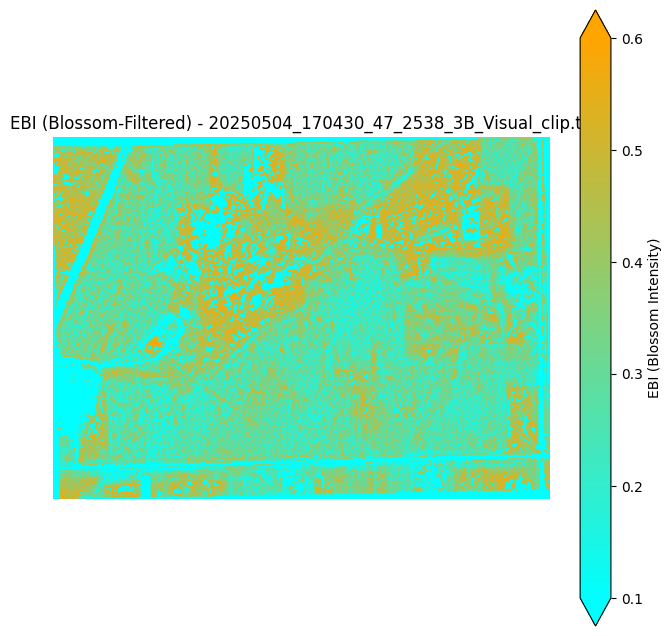

In [36]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Custom colormap from blue -> red
cmap = mcolors.LinearSegmentedColormap.from_list("cyan_orange", ["cyan", "orange"])

# When plotting
plt.figure(figsize=(8, 8))
im = plt.imshow(ebi_masked, cmap=cmap, vmin=0.1, vmax=0.6)
plt.colorbar(im, label="EBI (Blossom Intensity)", extend="both")
plt.title(f"EBI (Blossom-Filtered) - {os.path.basename(tif_path)}")
plt.axis("off")
plt.show()
